# Problème n°2 (1h)

Dans ce problème, il s'agit de tester une parade à l'imperfection des résultats au TP n°5, partie 2.

- Refaire tourner le code solution du TP°5 (avec deux échantillons de bruit noise et noise2 additionnels) en stockant les poids du réseau au bout de 40 époques.

- Pouvez-vous rappeler le défaut qui avait été observé dans la question 2 ?
  Ré-expliquez son origine en terme de médiane conditionnelle.

- Nous avons évoqué plusieurs parades, dont la régression quantile. Pouvez-vous expliquer en quoi cette forme de régression est adaptée ? Faites une expérience sur quarante époque en visant le quantile d'ordre 0.4 (dans la configuration initiale, c'est à dire avec deux échantillons de bruit seulement). Le problème est-il parfaitement résolu ? Faites une comparaison quantitative (limitée) à partir des images ne contenant que du bruit.


# Solution du TP°5/partie 2/exercice 2 (NES) + stockage des poids

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import torch.optim as optim


! git clone https://github.com/nanopiero/ML_S5_etudiants
! cp ML_S5_etudiants/practicals/P5/utile.py .
from utile import gen1_NES, gen2_NES, voir_batch2D, UNet

fatal: destination path 'ML_S5_etudiants' already exists and is not an empty directory.


In [6]:
import numpy as np
import torch
import torch.optim as optim
from copy import deepcopy

fcn = UNet(1, 1, 16).cuda()  # 1 canal entrée, 1 canal sortie, taille réseau: 16
optimizer = optim.Adam(fcn.parameters(), 1e-3)

def criterion(output, target):
    return torch.mean(torch.abs(output - target))

nepochs = 40
nbatches = 100
batchsize = 64

train_losses = []

for epoch in range(nepochs):
    print("Epoch " + str(epoch))
    epoch_losses = []

    for i in range(nbatches):
        # generation
        image = gen1_NES(batchsize).cuda()
        noise = gen2_NES(batchsize).cuda()
        noise2 = gen2_NES(batchsize).cuda()

        # build the sum
        input = image + noise + noise2
        target = image

        optimizer.zero_grad()
        output = fcn(input)

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.detach().cpu())

        del target, input, loss, image, noise, noise2, output
        torch.cuda.empty_cache()

    epoch_loss = float(np.mean(epoch_losses))
    train_losses.append(epoch_loss)
    print("epoch loss :\n", epoch_loss)

# Save weights in RAM (no file) at the end
weights_v2additional_noise = deepcopy({k: v.detach().cpu() for k, v in fcn.state_dict().items()})


Epoch 0
epoch loss :
 0.07940778881311417
Epoch 1
epoch loss :
 0.05945837125182152
Epoch 2
epoch loss :
 0.056062761694192886
Epoch 3
epoch loss :
 0.05485851317644119
Epoch 4
epoch loss :
 0.05393333360552788
Epoch 5
epoch loss :
 0.05268389731645584
Epoch 6
epoch loss :
 0.05215679109096527
Epoch 7
epoch loss :
 0.05080447718501091
Epoch 8
epoch loss :
 0.050839439034461975
Epoch 9
epoch loss :
 0.050684213638305664
Epoch 10
epoch loss :
 0.0512390099465847
Epoch 11
epoch loss :
 0.05019879713654518
Epoch 12
epoch loss :
 0.050138212740421295
Epoch 13
epoch loss :
 0.05097358301281929
Epoch 14
epoch loss :
 0.05068904906511307
Epoch 15
epoch loss :
 0.05026934668421745
Epoch 16
epoch loss :
 0.04996127262711525
Epoch 17
epoch loss :
 0.04969852417707443
Epoch 18
epoch loss :
 0.04985688254237175
Epoch 19
epoch loss :
 0.04940219968557358
Epoch 20
epoch loss :
 0.04922345653176308
Epoch 21
epoch loss :
 0.049725957214832306
Epoch 22
epoch loss :
 0.04940806329250336
Epoch 23
epoch lo

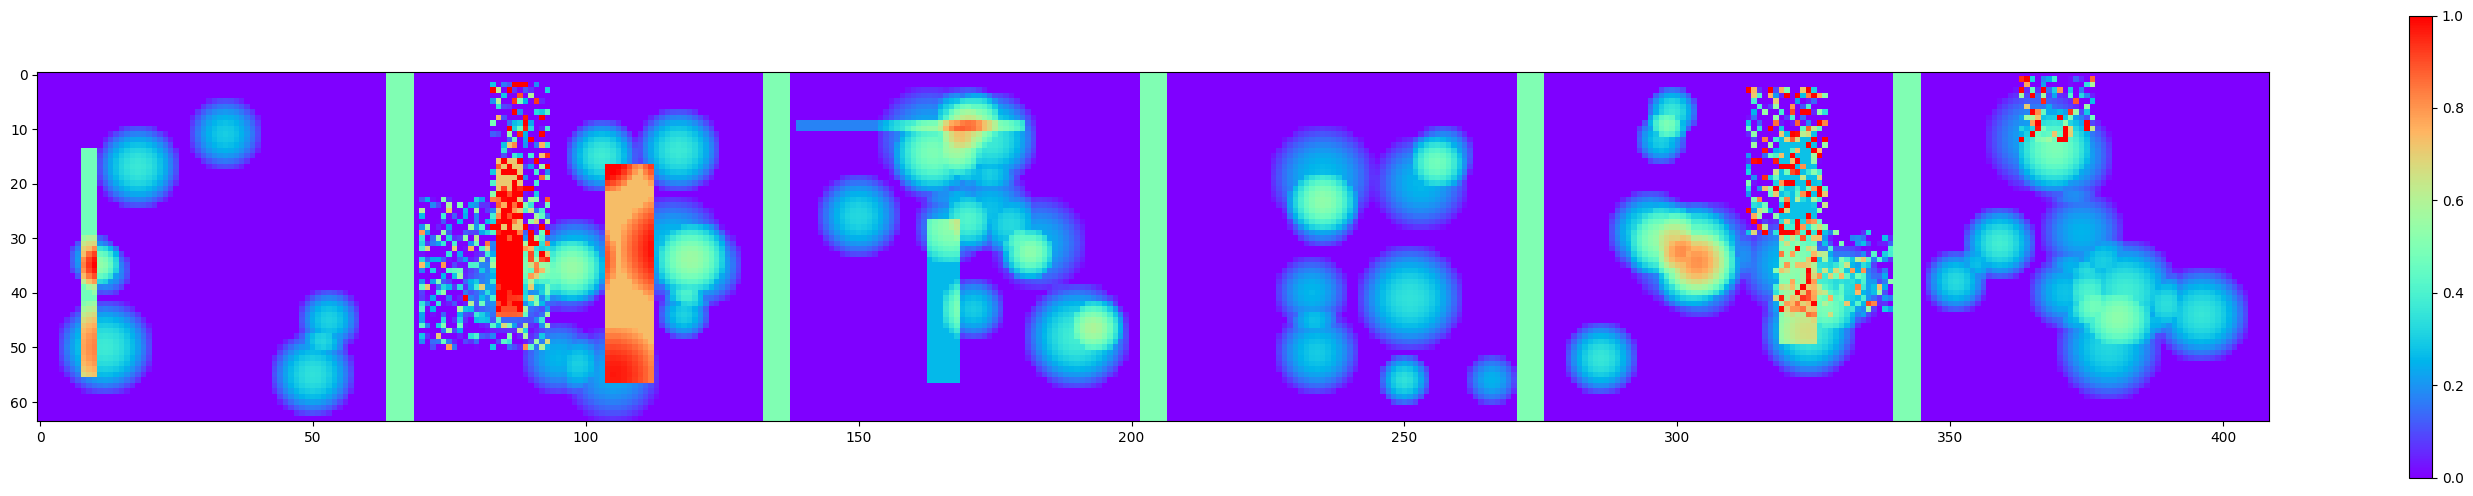

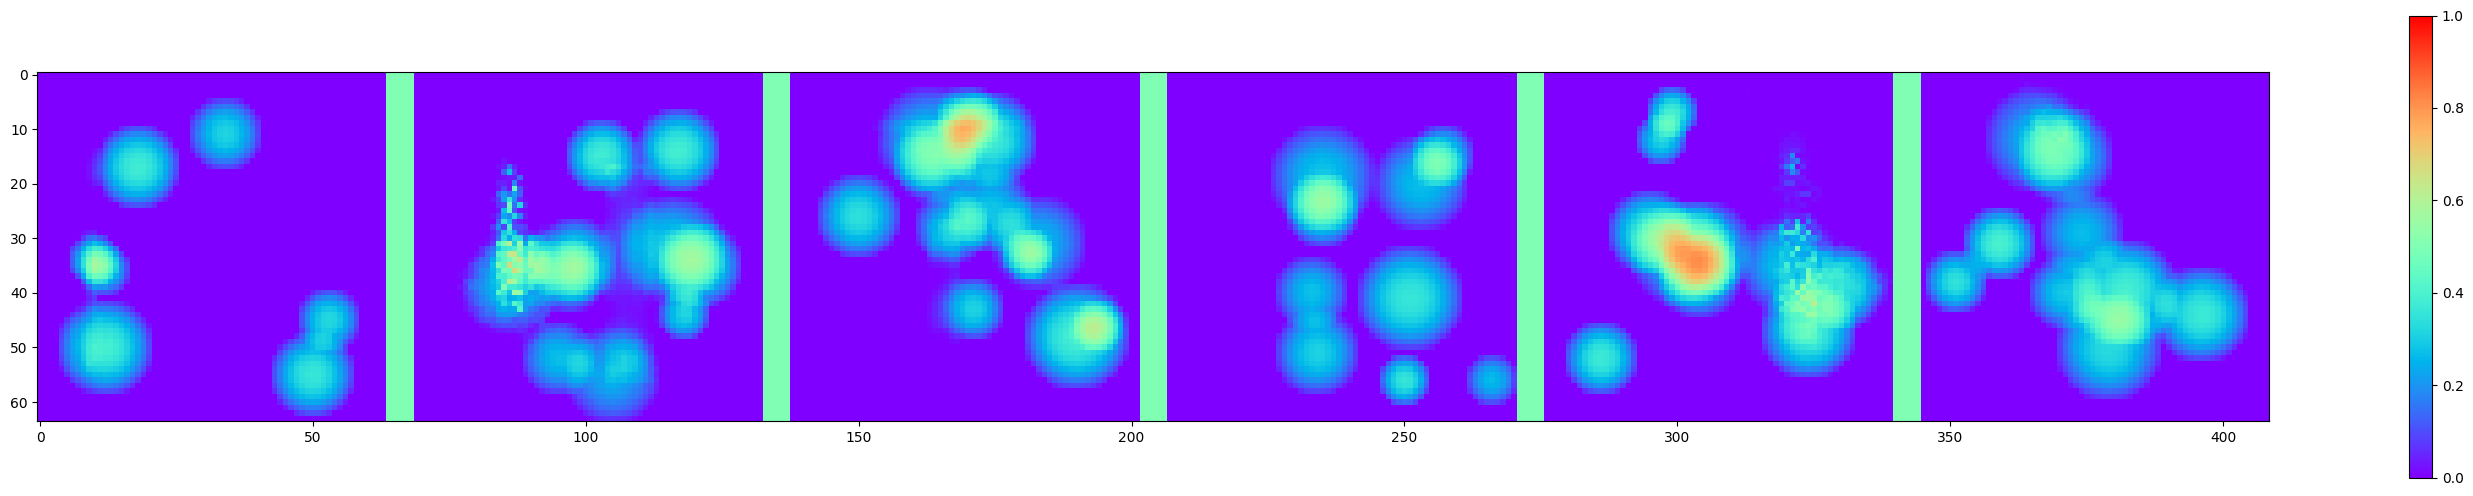

In [7]:
# --- Visualization (inputs / outputs) ---
fcn.eval()
with torch.no_grad():
    input = gen1_NES(6)
    output = fcn(input.cuda())

fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig, k=0, min_scale=0, max_scale=1)

fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(output.detach().cpu(), 6, fig2, k=0, min_scale=0, max_scale=1)

Le défaut se produisait dans le cas où les rectangles sont superposés. Dans ce cas, en effet, en un point donné, la médiane conditionnelle à l'image d'entrée n'est plus égale à l'image d'entrée "sans rectangle", mais lui est strictement supérieure, simplement parce que la probabilité que les deux rectangles viennent de l'image d'origine est égale à $(2/3)^2 = 4/9$ est inférieure à 0.5. Par contre, cette probablité est supérieure à 0.4.

# Nouvelle version avec régression quantile (q=0.4)

In [9]:
import numpy as np
import torch
import torch.optim as optim

fcn = UNet(1, 1, 16).cuda()
optimizer = optim.Adam(fcn.parameters(), 1e-3)

def rho(u, t):
    loss = t * u.clamp(min=0.) + (t - 1) * u.clamp(max=0.)
    loss = loss.mean()
    return loss

def criterion(output, target):
    return rho(target - output, 0.4)

nepochs = 40
nbatches = 100
batchsize = 64

train_losses = []

for epoch in range(nepochs):
    print("Epoch " + str(epoch))
    epoch_losses = []

    for i in range(nbatches):
        image = gen1_NES(batchsize).cuda()
        noise = gen2_NES(batchsize).cuda()
        noise2 = gen2_NES(batchsize).cuda()

        input = image + noise + noise2
        target = image

        optimizer.zero_grad()
        output = fcn(input)

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.detach().cpu())

        del target, input, loss, image, noise, noise2, output
        torch.cuda.empty_cache()

    epoch_loss = float(np.mean(epoch_losses))
    train_losses.append(epoch_loss)
    print("epoch loss :\n", epoch_loss)


Epoch 0
epoch loss :
 0.032502323389053345
Epoch 1
epoch loss :
 0.024226801469922066
Epoch 2
epoch loss :
 0.02274753525853157
Epoch 3
epoch loss :
 0.022119050845503807
Epoch 4
epoch loss :
 0.022040991112589836
Epoch 5
epoch loss :
 0.021535441279411316
Epoch 6
epoch loss :
 0.02165851555764675
Epoch 7
epoch loss :
 0.02130141481757164
Epoch 8
epoch loss :
 0.02127218060195446
Epoch 9
epoch loss :
 0.02081596851348877
Epoch 10
epoch loss :
 0.020755112171173096
Epoch 11
epoch loss :
 0.020989475771784782
Epoch 12
epoch loss :
 0.02057850919663906
Epoch 13
epoch loss :
 0.020218051970005035
Epoch 14
epoch loss :
 0.02047121711075306
Epoch 15
epoch loss :
 0.02007204107940197
Epoch 16
epoch loss :
 0.020236361771821976
Epoch 17
epoch loss :
 0.020255520939826965
Epoch 18
epoch loss :
 0.02056550420820713
Epoch 19
epoch loss :
 0.019979087635874748
Epoch 20
epoch loss :
 0.020125530660152435
Epoch 21
epoch loss :
 0.019869273528456688
Epoch 22
epoch loss :
 0.020006228238344193
Epoch 2

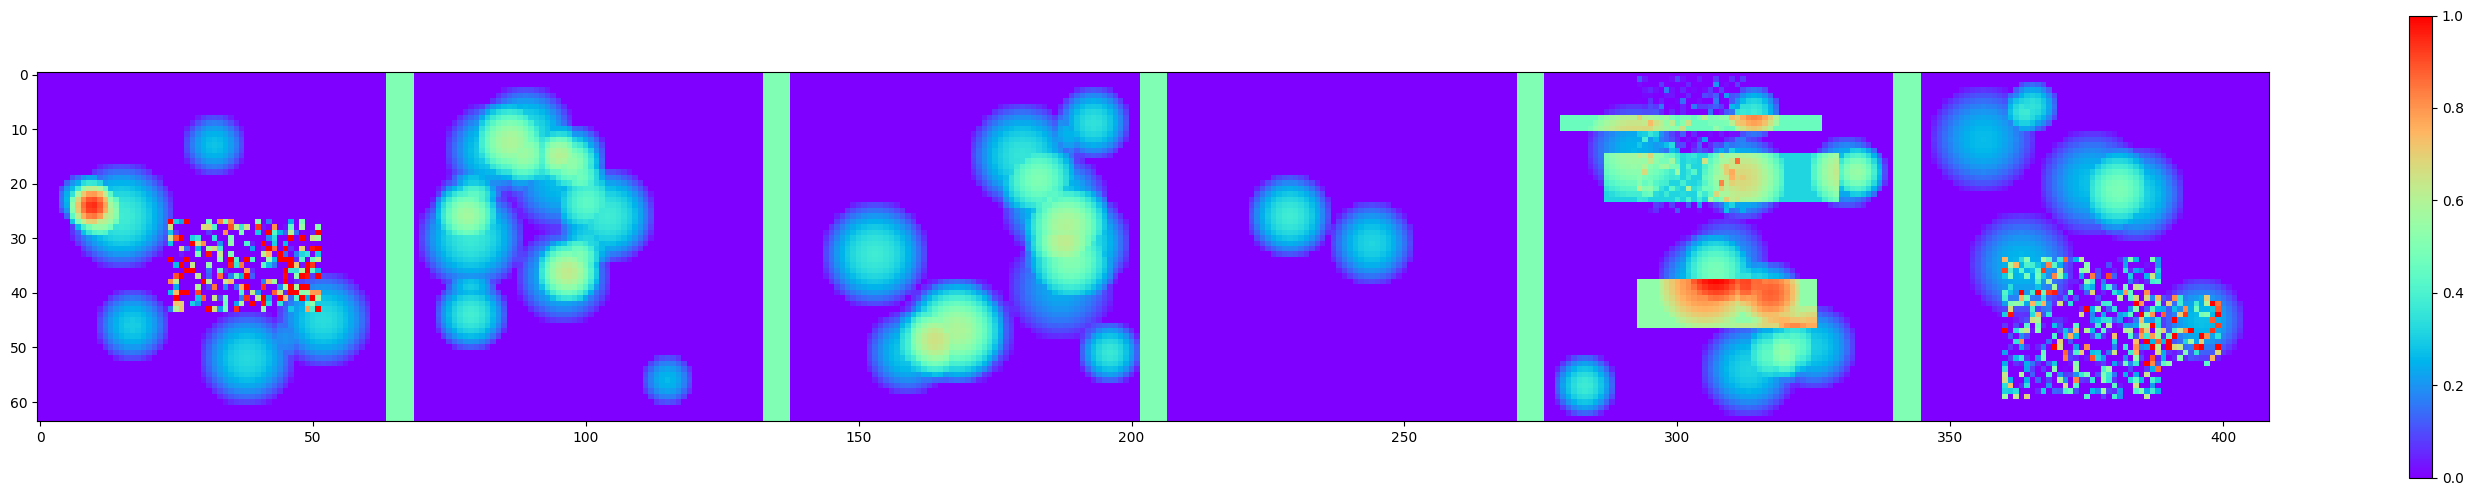

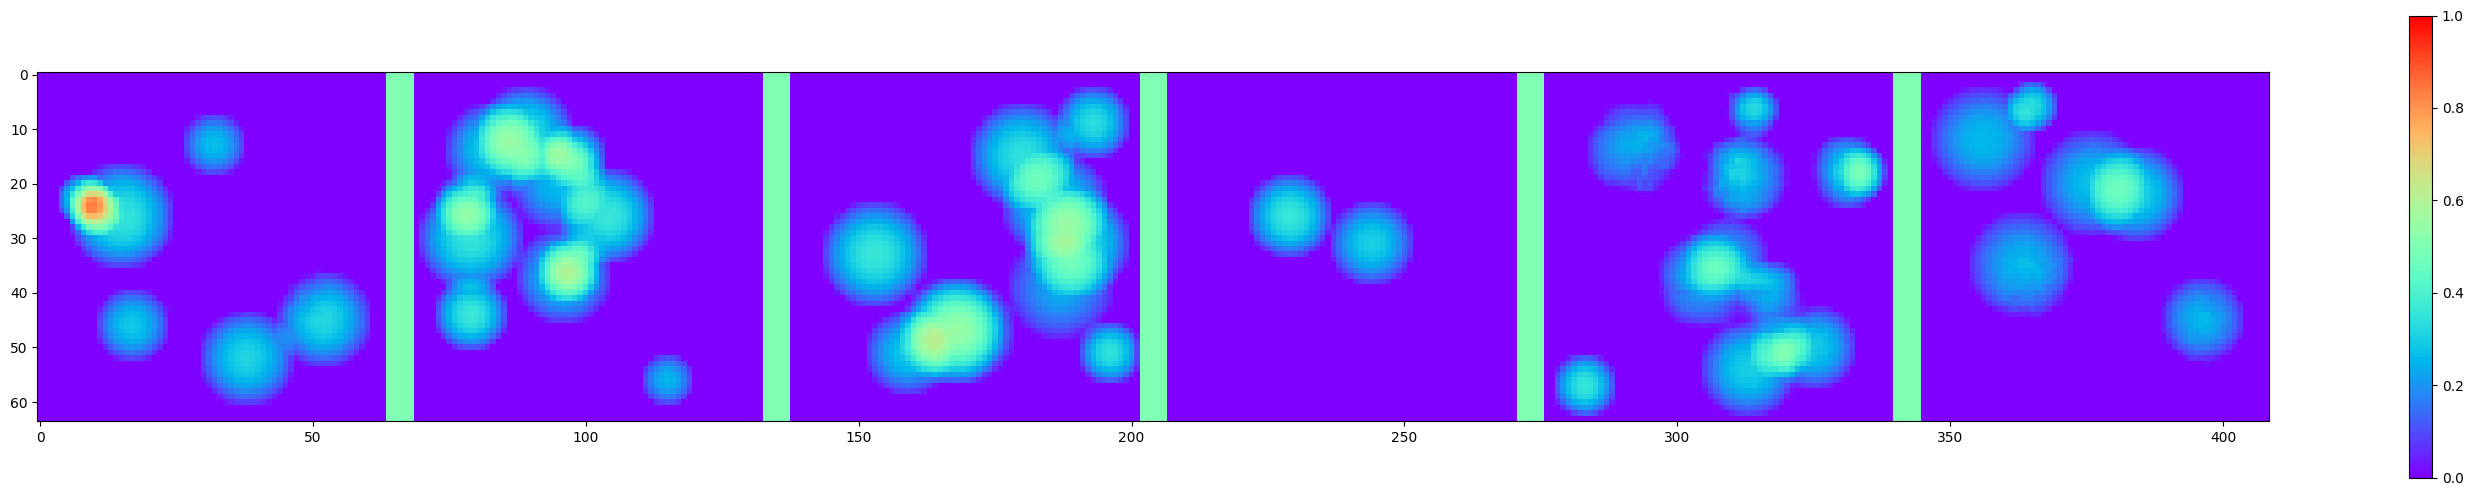

In [10]:
# --- Visualization (inputs / outputs) ---
fcn.eval()
with torch.no_grad():
    input = gen1_NES(6)
    output = fcn(input.cuda())

fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig, k=0, min_scale=0, max_scale=1)

fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(output.detach().cpu(), 6, fig2, k=0, min_scale=0, max_scale=1)

#  Comparaison quatitative sur des images ne contenant que du bruit

In [11]:
import torch
import numpy as np
from copy import deepcopy

# --- Rebuild models ---
fcn_L1 = UNet(1, 1, 16).cuda()
fcn_L1.load_state_dict(weights_v2additional_noise)
fcn_L1.eval()

fcn_q04 = fcn  # trained with pinball loss (quantile 0.4)
fcn_q04.eval()

# --- Generate noise-only test batch ---
batchsize_test = 64

with torch.no_grad():
    noise1 = gen2_NES(batchsize_test).cuda()
    noise2 = gen2_NES(batchsize_test).cuda()
    input_noise = noise1 + noise2           # no signal
    target_zero = torch.zeros_like(input_noise)

    # --- Forward passes ---
    out_L1  = fcn_L1(input_noise)
    out_q04 = fcn_q04(input_noise)

    # --- MAE vs zero field ---
    mae_L1  = torch.mean(torch.abs(out_L1  - target_zero)).item()
    mae_q04 = torch.mean(torch.abs(out_q04 - target_zero)).item()

print("Noise-only test (MAE vs zero):")
print(f"  L1-trained model        : {mae_L1:.6f}")
print(f"  Quantile 0.4 model      : {mae_q04:.6f}")


Noise-only test (MAE vs zero):
  L1-trained model        : 0.003406
  Quantile 0.4 model      : 0.000308


Le traitement est nettement plus efficace sur les images ne comportant que du bruit. Néanmoins, il reste des cas où, théoriquement au moins, le réseau devra maintenir un signal : si trois rectangles ou plus sont superposés, la probabilité qu'aucun ne provienne de l'image initiale inférieure ou égale à $(2/3)^3 = 8/27$, et le quantile d'ordre $0.4$ sera donc strictement positif au niveau de l'intersection.

**N.B.** Ces raisonnements ne sont possibles que parce que les signaux, disques et rectangles, sont parfaitement identifiables (sauf cas très rare de superposition parfaite).  